In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import glob
import os
import sys
from pathlib import Path
from PIL import Image

# disable GPU
# os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

import tensorflow as tf
import tensorflow.keras as keras


In [2]:
MODEL_NAME = "512d5f40_B123457_jd2"

IN_DIR = Path("./netin")
OUT_DIR = Path("./netout")
LOAD_SIZE = 16

BAND_DIRS = sorted(list(IN_DIR.glob("B*")))
display(BAND_DIRS)

[PosixPath('netin/B1'),
 PosixPath('netin/B2'),
 PosixPath('netin/B3'),
 PosixPath('netin/B4'),
 PosixPath('netin/B5'),
 PosixPath('netin/B6')]

In [3]:
MAX_X = 255

def read_fname(fname):
    bands = np.asarray([np.array(Image.open(band_dir / fname)) for band_dir in BAND_DIRS]) / MAX_X
    mchannel = np.dstack(bands)
    return mchannel

def rgb_transform(ds):
#     return np.flip(ds, 3)  # Bands 2, 3, 4 -> rgb
    return np.flip(ds[:,:,:,1:4], 3)  # Bands 1, 2, 3, 4, 5, 7 -> rgb

In [4]:
band1_paths = list(BAND_DIRS[0].glob("*.png"))

In [5]:
def readin_batch(band1pths):
    img_lst = []
    img_names = []
    for imgpth in band1pths:
        img = read_fname(imgpth.name)
        img_lst.append(img)
        img_names.append(imgpth.name)
    return img_names, np.asarray(img_lst)

def divide_chunks(l, n): 
    # https://www.geeksforgeeks.org/break-list-chunks-size-n-python/
    # looping till length l 
    for i in range(0, len(l), n):  
        yield l[i:i + n] 

In [6]:
def write_out_img(name, img_data):
    imga = tf.cast(img_data * 255, tf.uint8)
    imgencoded = tf.image.encode_png(imga)
    out_file = OUT_DIR / name
    tf.io.write_file(out_file.as_posix(), imgencoded)

In [7]:
from keras_unet.models import custom_unet

input_shape = (512, 512, 6)  # 6 channel image
# input_shape = (512, 512, 3)  # rgb image

model = custom_unet(
    input_shape,
    filters=40,
    use_batch_norm=True,
    dropout=0.15,  # 0.3
    dropout_change_per_layer=0.0,
    num_layers=5
)

display(model.summary())

-----------------------------------------
keras-unet init: TF version is >= 2.0.0 - using `tf.keras` instead of `Keras`
-----------------------------------------
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 6) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 512, 512, 40) 2160        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 512, 512, 40) 160         conv2d[0][0]                     
__________________________________________________________________________________________________
spatial_dropout2d (SpatialDropo

None

In [8]:
model_filename = f'{MODEL_NAME}.h5'
model.load_weights(model_filename)

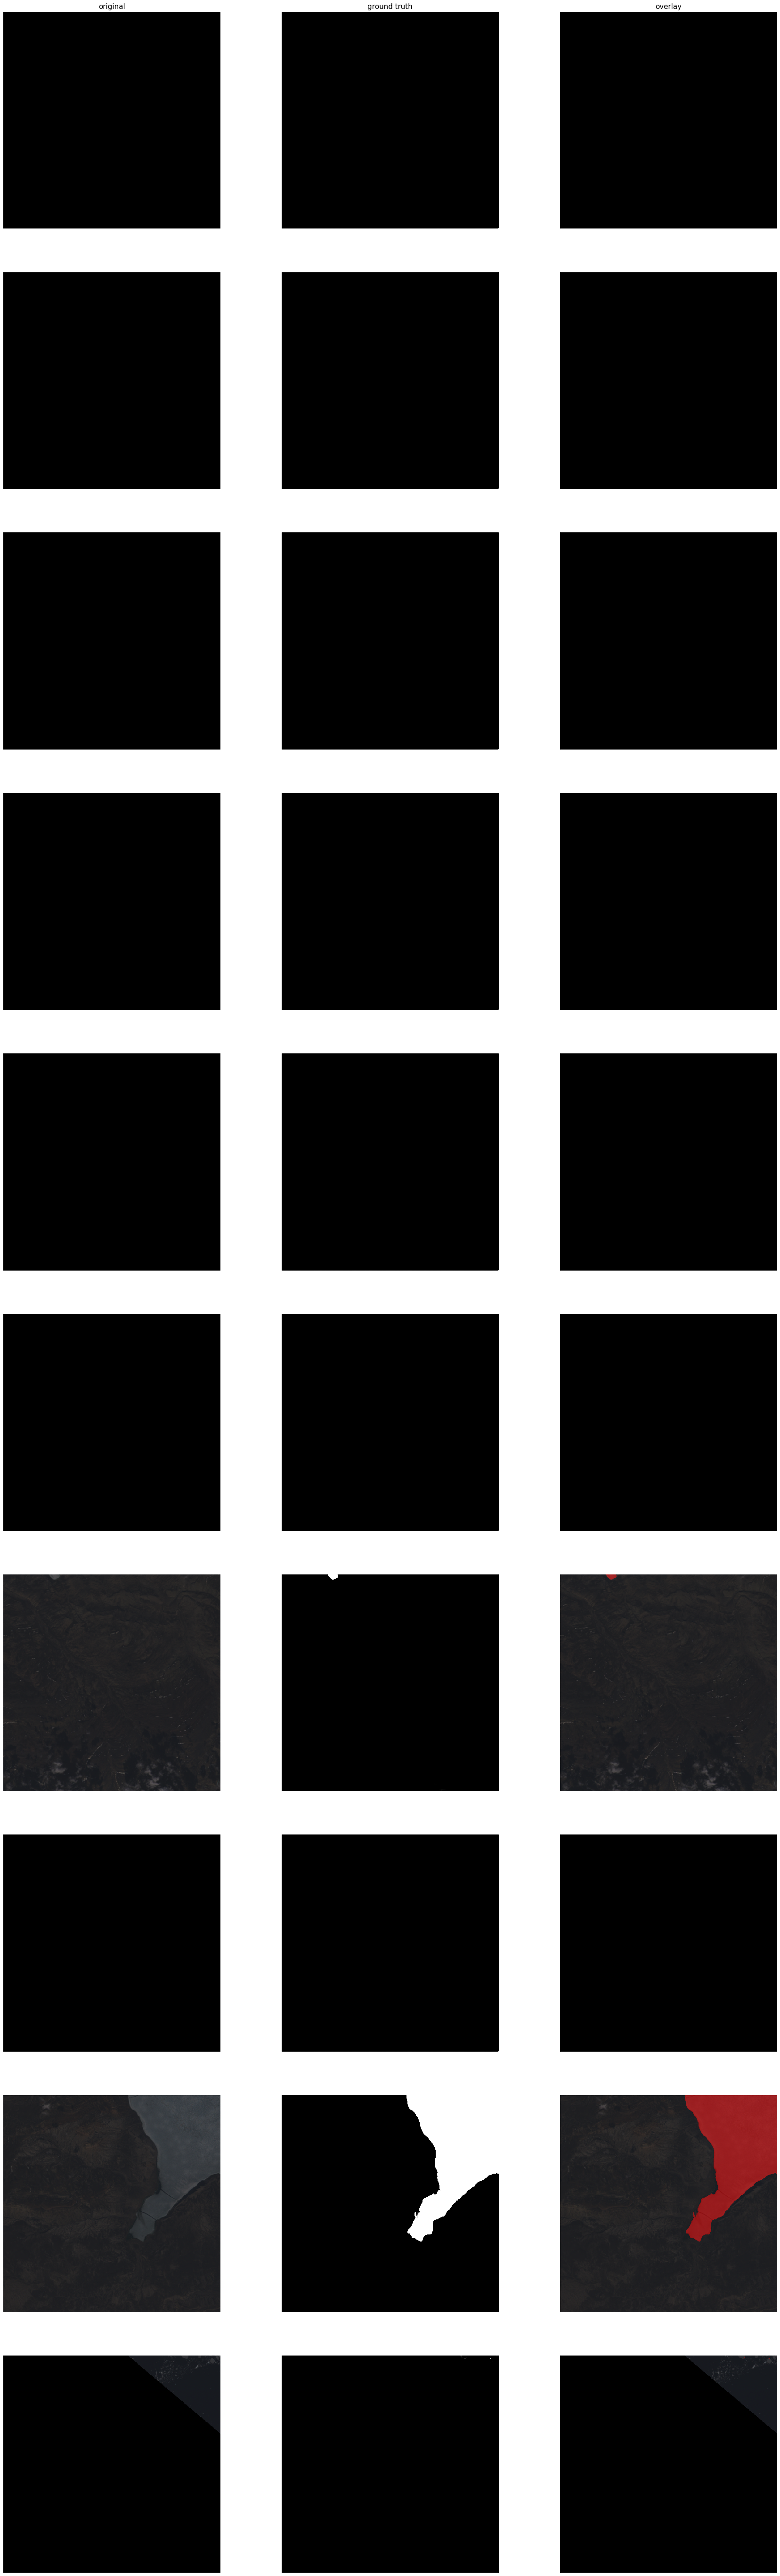

In [9]:
from keras_unet.utils import plot_imgs

for batch in divide_chunks(band1_paths, LOAD_SIZE):
    names, x_pred = readin_batch(batch)
    y_pred = model.predict(x_pred)
    plot_imgs(org_imgs=rgb_transform(x_pred), mask_imgs=y_pred, nm_img_to_plot=10, figsize=10)
    break
    for name, pred in zip(names, y_pred):
        write_out_img(name, pred)